In [1]:
import sys
import os
from typing import Dict, List, Tuple
import gymnasium as gym
import collections
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from environment_rev import PNDEnv

# Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
    
class Policy(nn.Module):
    def __init__(self, state_space=2, action_space=2):
        super(Policy, self).__init__()
        self.data = []
        self.state_space = state_space
        self.hidden_space = 4
        self.action_space = action_space
        self.linear1 = nn.Linear(self.state_space, self.hidden_space)
        self.lstm = nn.LSTM(self.hidden_space, self.hidden_space)
        self.linear2 = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x = F.relu(self.linear1(x))
        x, (new_h, new_c) = self.lstm(x, (h, c))
        x = F.softmax(self.linear2(x), dim=2)
        return x, new_h, new_c

    def put_data(self, transition):
        self.data.append(transition)

    def sample_action(self, obs, h, c):
        output = self.forward(obs, h, c)
        # Select action with respect to the action probabilities
        action = torch.squeeze(output[0]).multinomial(num_samples=1)    
        return action.item(), output[1], output[2]
    
    def init_hidden_state(self):
        return torch.zeros(1, 1, self.hidden_space, device=device), torch.zeros(1, 1, self.hidden_space, device=device)

def train(pi, optimizer):
    R = 0
    policy_loss = []
    optimizer.zero_grad()
    for r, prob in pi.data[::-1]:
        R = r + gamma * R
        loss = -torch.log(prob) * R # Negative score function x reward
        policy_loss.append(loss)
    sum(policy_loss).backward()
    optimizer.step()
    pi.data = []
    

# Set parameters
batch_size = 8
learning_rate = 1e-3
buffer_len = int(100000)
min_epi_num = 10 # Start moment to train the Q network
episodes = 500
target_update_period = 10
eps_start = 0.1
eps_end = 0.001
eps_decay = 0.995
tau = 1e-2

# DRQN param
random_update = True    # If you want to do random update instead of sequential update
lookup_step = 20        # If you want to do random update instead of sequential update

# Number of envs param
n_nodes = 10
n_agents = 10
density = 1
max_step = 300
model = "dumbbell"

# Set gym environment
env_params = {
    "n": n_nodes,
    "density": density,
    "max_episode_length": max_step,
    "model": model
    }
if model == None:
    env_params_str = f"n{n_nodes}_density{density}_max_episode_length{max_step}"
else:
    env_params_str = f"n{n_nodes}_model{model}_max_episode_length{max_step}"

In [2]:
env = PNDEnv(**env_params)
env.reset()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 None)

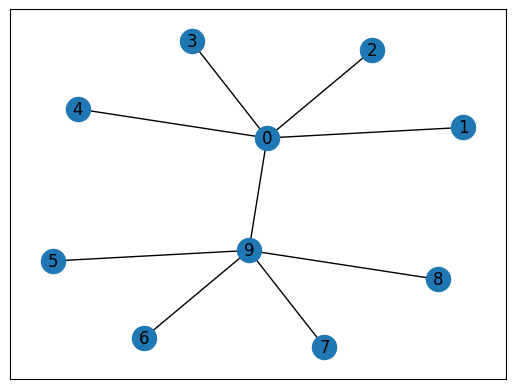

In [3]:
output_path = 'outputs/DRQN_'+env_params_str
writer = SummaryWriter(filename_suffix=env_params_str)
if not os.path.exists(output_path):
    os.makedirs(output_path)
env.save_graph_with_labels(output_path)

In [4]:
# Create Policy functions
n_states = 2
n_actions = 2

pi_cum = [Policy(state_space=n_states, action_space=n_actions).to(device) for _ in range(n_agents)]

In [5]:
# Set optimizer
score = 0
score_sum = 0
optimizer_cum = [optim.Adam(pi_cum[i].parameters(), lr=learning_rate) for i in range(n_agents)]

epsilon = eps_start

df = pd.DataFrame(columns=['episode', 'time'] + [f'action_{i}' for i in range(n_agents)] + [f'age_{i}' for i in range(n_agents)])
appended_df = []

In [6]:
for i_epi in tqdm(range(episodes), desc="Episodes", position=0, leave=True):
    s, _ = env.reset()
    obs_cum = [s[np.array([x, x+n_agents])] for x in range(n_agents)]
    h_cum, c_cum = zip(*[pi_cum[i].init_hidden_state() for i in range(n_agents)])
    done = False
    
    for t in tqdm(range(max_step), desc="   Steps", position=1, leave=False):
        prob_cum = [pi_cum[i](torch.from_numpy(obs_cum[i]).float().unsqueeze(0).unsqueeze(0).to(device), h_cum[i].to(device), c_cum[i].to(device))[0] for i in range(n_agents)]
        a_cum, h_cum, c_cum = zip(*[pi_cum[i].sample_action(torch.from_numpy(obs_cum[i]).float().unsqueeze(0).unsqueeze(0).to(device), h_cum[i].to(device), c_cum[i].to(device)) for i in range(n_agents)])
        a_cum = np.array(a_cum)
        s_prime, r, done, _, info = env.step(a_cum)
        done_mask = 0.0 if done else 1.0
        for i in range(n_agents):
            a = a_cum[i]
            pi_cum[i].put_data((r, prob_cum[i][0, 0, a]))
        obs_cum = [s_prime[np.array([x, x+n_agents])] for x in range(n_agents)]
        score += r
        
        if done:
            break

    for pi, optimizer in zip(pi_cum, optimizer_cum):
        train(pi, optimizer)
    
    print(f"n_episode: {i_epi}/{episodes}, score: {score}")
    score = 0

env.close()

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 0/500, score: 137.49999999999983


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 1/500, score: 173.13666666666654


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 2/500, score: 142.16666666666686


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 3/500, score: 99.50000000000014


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 4/500, score: 141.3933333333333


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 5/500, score: 121.16333333333326


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 6/500, score: 150.07000000000002


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 7/500, score: 163.11666666666656


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 8/500, score: 139.75333333333347


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 9/500, score: 142.48333333333326


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 10/500, score: 149.46


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 11/500, score: 123.04333333333324


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 12/500, score: 172.4433333333332


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 13/500, score: 152.10333333333327


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 14/500, score: 147.38666666666663


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 15/500, score: 138.9666666666668


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 16/500, score: 115.50000000000014


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 17/500, score: 136.3300000000001


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 18/500, score: 166.2666666666666


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

n_episode: 19/500, score: 142.6000000000001


   Steps:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 